# Capstone Project - Invasive Species Monitoring

**Description:**

Tangles of kudzu overwhelm trees in Georgia while cane toads threaten habitats in over a dozen countries worldwide. These are just two invasive species of many which can have damaging effects on the environment, the economy, and even human health. Despite widespread impact, efforts to track the location and spread of invasive species are so costly that they’re difficult to undertake at scale.

Currently, ecosystem and plant distribution monitoring depends on expert knowledge. Trained scientists visit designated areas and take note of the species inhabiting them. Using such a highly qualified workforce is expensive, time inefficient, and insufficient since humans cannot cover large areas when sampling.

Because scientists cannot sample a large quantity of areas, some machine learning algorithms are used in order to predict the presence or absence of invasive species in areas that have not been sampled. The accuracy of this approach is far from optimal, but still contributes to approaches to solving ecological problems.

[Kaggle - https://www.kaggle.com/c/invasive-species-monitoring]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras.preprocessing import image
import cv2
%matplotlib inline

In [3]:
df = pd.read_csv('../capstone_project_data/train_labels.csv')
#df.set_index('name', inplace=True)
invasive_species = df[df['invasive'] == 1]
non_invasive_species = df[df['invasive'] == 0]
images = df['name'].values
labels = df['invasive'].values

In [4]:
def plot_random_images(df):
    fig = plt.figure(figsize=(15, 15), tight_layout=True)
    for i in range (1, 7):
        sample = df.sample(1)
        a = fig.add_subplot(2, 3, i)
        img_path = '../capstone_project_data/train/{}.jpg'.format(sample['name'].values[0])
        img = image.load_img(img_path, target_size=(224, 224))
        a.imshow(img)
    #plt.subplots_adjust(wspace=0, hspace=3)
    plt.show()

**Plot Invasive species images**

/Users/vaibhavchakki/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


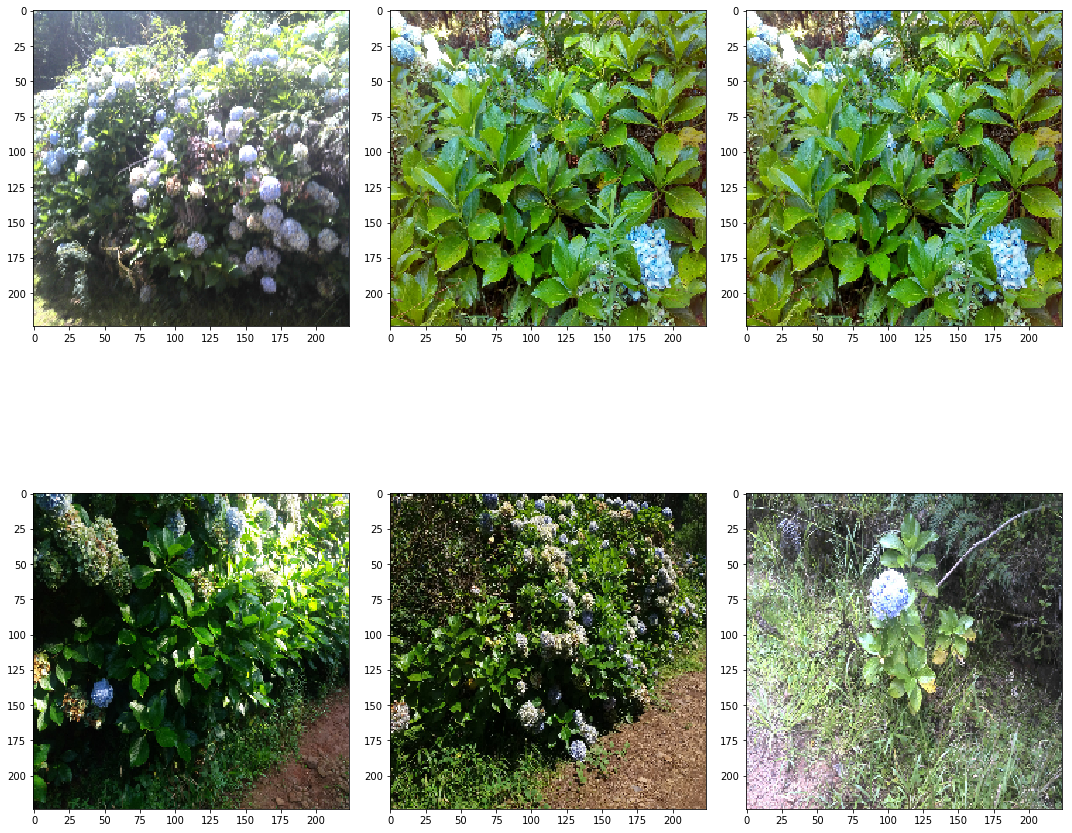

In [5]:
plot_random_images(invasive_species)

**Plot Non-Invasive species images**

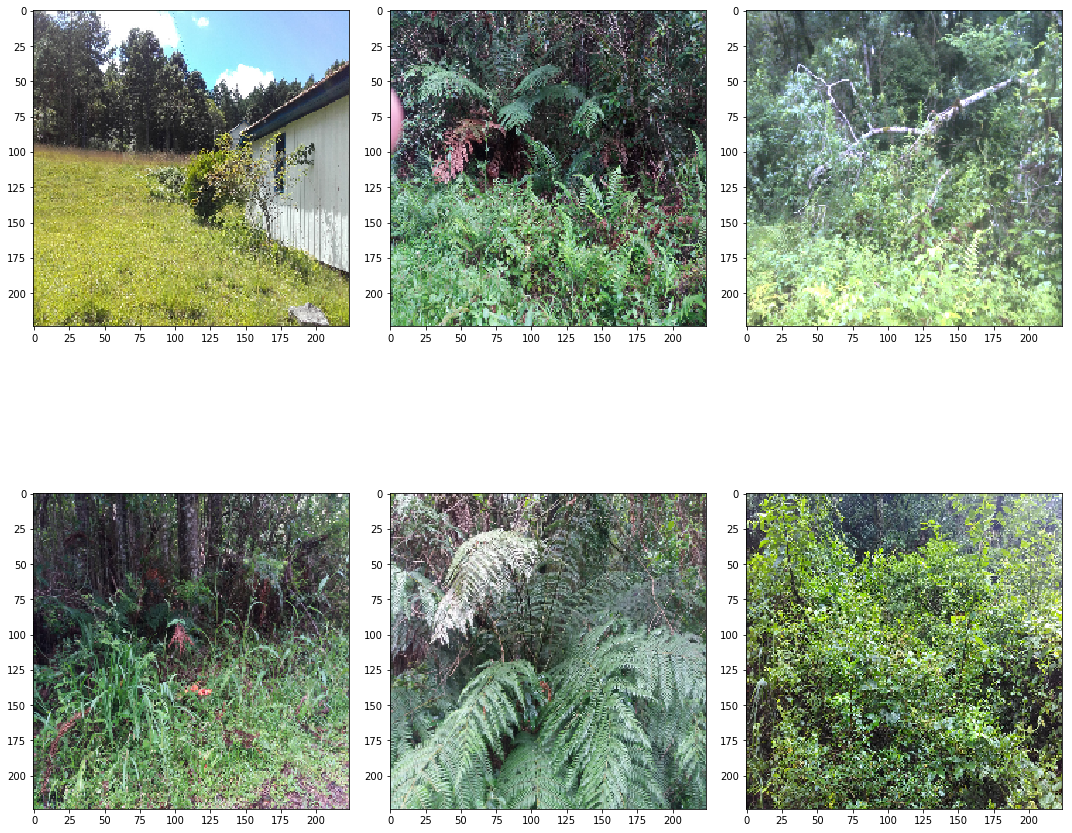

In [6]:
plot_random_images(non_invasive_species)

**Dataset Pre Processing and Dataset Augmentation**

Since the original dataset has limited images, to improve accuracy we augument the data with additional images by applying the below image processing techniques:

1. Randomly change brightness of image 
2. Randomly change the sharpness of image
3. Randomly flip the image horizontally
4. Randomly shift the image 
5. Randomly rotate the image

As part of image pre-processing we resize the image to (299, 299), convert RGB image to YUV, and then normalize the image. After the proprocesing step is done the image is used to train the Convlutional Neural Network (CNN)

In [16]:
from keras.utils import np_utils
from PIL.ImageEnhance import Brightness, Color, Contrast, Sharpness

#
# Apply ZCA whitening to image
def zca_whitening(x, zca_epsilon = 1e-6):
    #
    # compute PCA first
    flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
    sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
    u, s, _ = linalg.svd(sigma)
    principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + zca_epsilon))), u.T)

    #
    # Now perform zca whitening
    flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
    whitex = np.dot(flatx, principal_components)
    x = np.reshape(whitex, x.shape)

    return x

#
# Horizontally flip the image
def flip_horizontal(x):
    column_axis = 1
    x = image.flip_axis(x, column_axis)
    return x

#
# Generic method to change the brightness or sharpness of the image between
# low and high ranges
def apply_modify(image, function, low = 0.5, high = 1.5):
    factor = np.random.uniform(low, high)
    enhancer = function(image)
    return enhancer.enhance(factor)

#
# Preprocess the image before feeding to the CNN
def pre_process_img(img, enable_zca = False,
                    enable_yuv = True,
                    training = False,
                    normalize = True,
                    target_size = (299, 299)):

    img_path = '../capstone_project_data/train/{}.jpg'.format(img)
    x = image.load_img(img_path, target_size = target_size)

    if training:
        if np.random.random() < 0.5:
            x = apply_modify(x, Brightness, .8, 1.2)
        if np.random.random() < 0.5:
            x = apply_modify(x, Sharpness, 1., 2.)

    x = image.img_to_array(x)

    if training:
        if np.random.random() < 0.5:
            x = flip_horizontal(x)
        if np.random.random() < 0.5:
            x = image.random_shift(x, 0.2, 0., row_axis = 0, col_axis = 1, channel_axis = 2)
        if np.random.random() < 0.5:
            x = image.random_rotation(x, 30., row_axis = 0, col_axis = 1, channel_axis = 2)


    if enable_yuv:
        x = cv2.cvtColor(x, cv2.COLOR_RGB2YUV)

    if enable_zca:
        x = zca_whitening(x)

    if normalize:
        #
        # Normalize the image
        x = (x / 255. - 0.5).astype('float32')

    return x

**Images after preprocessing**

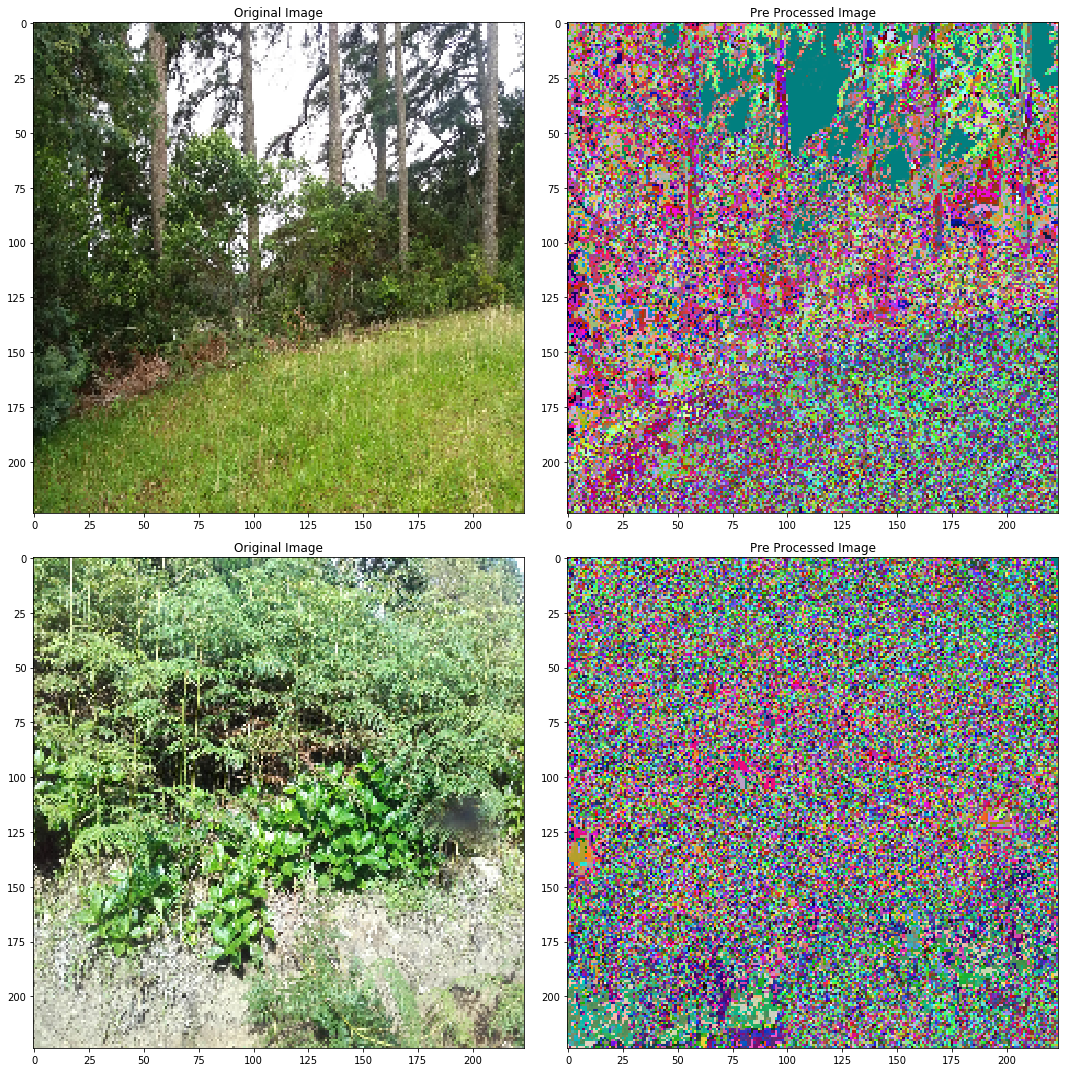

In [18]:
fig = plt.figure(figsize=(15, 15), tight_layout=True)
sample = df.sample(1)
a = fig.add_subplot(2, 2, 1)
a.set_title("Original Image")
img_path = '../capstone_project_data/train/{}.jpg'.format(sample['name'].values[0])
img = image.load_img(img_path, target_size=(224, 224))
a.imshow(img)
a = fig.add_subplot(2, 2, 2)
a.set_title("Pre Processed Image")
img = pre_process_img(sample['name'].values[0], enable_zca = False, enable_yuv = True, training = False,
                      normalize = False, target_size = (224, 224))
a.imshow(img)
sample = df.sample(1)
a = fig.add_subplot(2, 2, 3)
a.set_title("Original Image")
img_path = '../capstone_project_data/train/{}.jpg'.format(sample['name'].values[0])
img = image.load_img(img_path, target_size=(224, 224))
a.imshow(img)
a = fig.add_subplot(2, 2, 4)
a.set_title("Pre Processed Image")
img = pre_process_img(sample['name'].values[0], enable_zca = False, enable_yuv = True, training = False,
                      normalize = False, target_size = (224, 224))
a.imshow(img)
plt.show()

** Convolutional Neural Model **

We here use the Inception V3 model from Keras to build the CNN. An inception V3 model is a trained model on imagenet with 1000 classes. We use transfer learning technique here, we used an already trained Inception V3 CNN model on imagenet, and then we add layers at the output from the Inception V3 to match the number of classes. 

We use Adam optimizer in our model to minimize the loss. The reason for using Adam optimizer is because it converges faster compard to Stochastic Gradient Descent (SGD), with very less tuning. However with proper tunning SGD can also achieve comparable or better performance than Adam Optimizer in Practice.

** Model Hyper parameters **
1. Learning rate - Tried different learning rate and the best learning rate of 0.0001 worked better accuracy
2. Number of epochs - This parameter was primarly limited in my simulation to time used, so choose value of 4
3. Batch Size - Tried batch sizes of 8, 16, 32, 64. The best that worked was 16 on my system

In [9]:
import json
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam, SGD

def validation_generator(batch_size, test_data, test_label):
    while True:
        x = []
        y = []

        for i in range(batch_size):
            index = np.random.randint(len(test_data) - 1)

            img = test_data[index]
            label = test_label[index]

            img = pre_process_img(img)

            x.append(img)
            y.append(label)

        yield np.array(x), np.array(y)


def training_generator(batch_size, train_data, train_label):
    while True:
        x = []
        y = []

        for i in range(batch_size):
            index = np.random.randint(len(train_data) - 1)

            img = train_data[index]
            label = train_label[index]

            img = pre_process_img(img, training = True)

            x.append(img)
            y.append(label)

        yield np.array(x), np.array(y)
        
def get_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.25)(x)
    pred = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=pred)
    #adam = Adam(lr=0.001)
    #sgd = SGD(lr=0.0001, momentum=0.9)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = Adam(lr=0.0001),
                  metrics = ['accuracy'])
    return model



def train_model():

    df = pd.read_csv('../capstone_project_data/train_labels.csv')
    images = df['name'].values
    labels = df['invasive'].values
    batch_size = 16

    train_x, test_x, train_y, test_y = train_test_split(images, labels,
                                                        test_size = 0.2,
                                                        random_state = 42)

    print("Train Size: %d" % len(train_x))
    print("Test Size: %d" % len(test_x))

    train_y = np_utils.to_categorical(train_y)
    test_y  = np_utils.to_categorical(test_y)

    num_classes = train_y.shape[1]
    print("Num classes %d" % num_classes)

    model = get_model(num_classes)

    model.fit_generator(training_generator(batch_size, train_x, train_y),
                        steps_per_epoch=len(train_x) // batch_size,
                        epochs = 4,
                        verbose = 1,
                        callbacks = [],
                        validation_data = validation_generator(batch_size, test_x, test_y),
                        validation_steps = len(test_x) // batch_size)

    with open("model.json", "w") as fp:
        json.dump(model.to_json(), fp)

    model.save_weights("model.h5", overwrite = True)

    print("Done!!!")


** Metrics **

1. Accuracy / Loss - Categorical Cross entropy - For CNN, its recomended to use Categorical Cross entropy for CNN with softmax activation and one hot encoded target

In [10]:
train_model()

Train Size: 1836
Test Size: 459
Num classes 2
Epoch 1/4
114/114 [==============================] - 2173s - loss: 0.2650 - acc: 0.8942 - val_loss: 0.1534 - val_acc: 0.9554
Epoch 2/4
114/114 [==============================] - 2161s - loss: 0.1295 - acc: 0.9518 - val_loss: 0.0596 - val_acc: 0.9688
Epoch 3/4
114/114 [==============================] - 2259s - loss: 0.1083 - acc: 0.9622 - val_loss: 0.0862 - val_acc: 0.9598
Epoch 4/4
114/114 [==============================] - 2321s - loss: 0.1089 - acc: 0.9583 - val_loss: 0.1139 - val_acc: 0.9576
Done!!!


** Conclusion **

1. CNN are best suited for Deep Learning
2. Data pre-processing and data augmentation are necessary steps for imporved accuracy and faster convergence
3. Tuning hyper-parameters like learning rate, number of epochs, batch_size are equally important for good accuracy score
4. Keras library is great way to learn and implement Deep Learning using CNN
5. With only 4 epochs, I was able to achieve > 95% accuracy
